# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


from sqlalchemy import create_engine
from dotenv import load_dotenv
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn._config import set_config
from sklearn.model_selection import train_test_split

set_config(transform_output='pandas')


# Loading the data and saving it into a .csv file

In [2]:
# Load environment variables
load_dotenv()

# Retrieve database connection string from .env file
DB_STRING = os.getenv('DB_STRING')
DB_TABLE = os.getenv('DB_TABLE')  # Specify the table you want to fetch
DB_SCHEMA = os.getenv('DB_SCHEMA')  # Specify the schema if needed

# Create a database engine
engine = create_engine(DB_STRING)


# Define SQL query string
query_string = f'SELECT * FROM {DB_SCHEMA}.{DB_TABLE}'

# Read data from the database into a Pandas DataFrame
df_eda = pd.read_sql(query_string, engine)

# Ensure 'data' directory exists
os.makedirs('data', exist_ok=True)

# Save the DataFrame as a CSV file
csv_path = os.path.join('data', f'{DB_TABLE}.csv')
df_eda.to_csv(csv_path, index=False)

print(f'Data successfully saved to {csv_path}')


Data successfully saved to data/k_notifications.csv


# Data Cleaning/EDA

Load the data from the .csv file and save it in a DataFrame for the Data analysis:

In [3]:
df_model = pd.read_csv('data/k_notifications.csv')
df_eda = df_model.copy()

In [4]:
df_eda.head()

,timestamp,user_id,friend_id,friend_name
0,2017-08-01 00:06:47,F62712701E7AF6588B69A44235A6FC,06D188F4064E0D47BD760EEFEB7AAD,Geir
1,2017-08-01 00:31:05,DF5BB50FAD220C8D2A8FF9A0DBAA47,588C89FCADD0DBA0E722822513A267,Antim
2,2017-08-01 00:35:24,8473CCCE79294CB494D1B42E2B1BAA,EDBB3D240ADBCF6CF175B192630ABB,Σωτήριος
3,2017-08-01 01:20:47,CFFEC5978B0A4A05FA6DCEFB2C82CC,2BB0471CAA78ED0FCEE143E175F034,Mona
4,2017-08-01 01:21:39,0978C6F8C5093039165B5C571EACC8,45FE4C99C612BEEDE6A34B54C5369D,Laura


In [5]:
df_eda.shape

(337657, 4)

In [6]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337657 entries, 0 to 337656
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   timestamp    337657 non-null  object
 1   user_id      337657 non-null  object
 2   friend_id    337657 non-null  object
 3   friend_name  337657 non-null  object
dtypes: object(4)
memory usage: 10.3+ MB


The timestamp is an Object, so we convert it to a pandas timeframe object, and add a column for the specific day, and the time for further analysis

In [7]:
df_eda.timestamp = pd.to_datetime(df_eda.timestamp)
df_eda['day'] = df_eda['timestamp'].dt.date  # Extract the day
df_eda['hour'] = df_eda['timestamp'].dt.hour # Extract the hour of the day
df_eda['weekday'] = df_eda['timestamp'].dt.weekday # Extract the weekday

In [8]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337657 entries, 0 to 337656
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   timestamp    337657 non-null  datetime64[ns]
 1   user_id      337657 non-null  object        
 2   friend_id    337657 non-null  object        
 3   friend_name  337657 non-null  object        
 4   day          337657 non-null  object        
 5   hour         337657 non-null  int32         
 6   weekday      337657 non-null  int32         
dtypes: datetime64[ns](1), int32(2), object(4)
memory usage: 15.5+ MB


In [9]:
df_eda.day.nunique()

62

In [10]:
df_eda.columns

Index(['timestamp', 'user_id', 'friend_id', 'friend_name', 'day', 'hour',
       'weekday'],
      dtype='object')

Here we see that the Data is from 62 unique days.



Now we want to identify peak notification times, so we plot the time column against the time of day.

<Axes: xlabel='hour'>

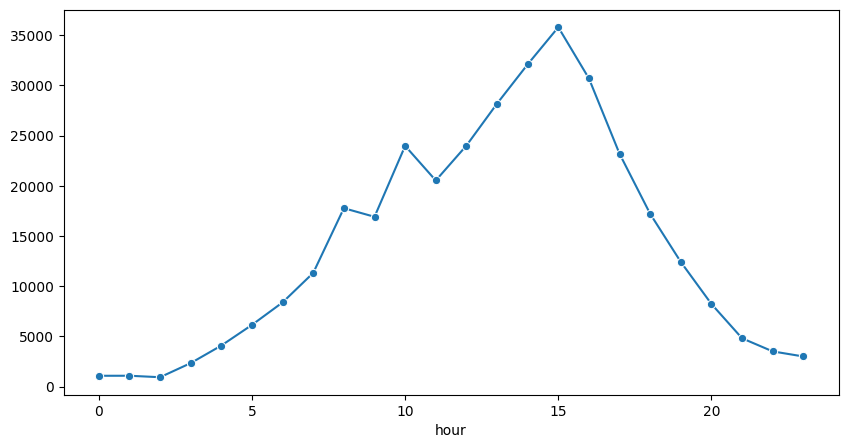

In [11]:
# Count occurrences per hour
hourly_counts = df_eda['hour'].value_counts().sort_index()

# Plot the line graph
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker="o")

Here we can see that the peak time for notifications is 15:00, and that there is barely any activity before 6:00 and after 21:00 which makes sense, because of people sleeping. This also indicates that the people that are connected are roughly in the same timezone. 

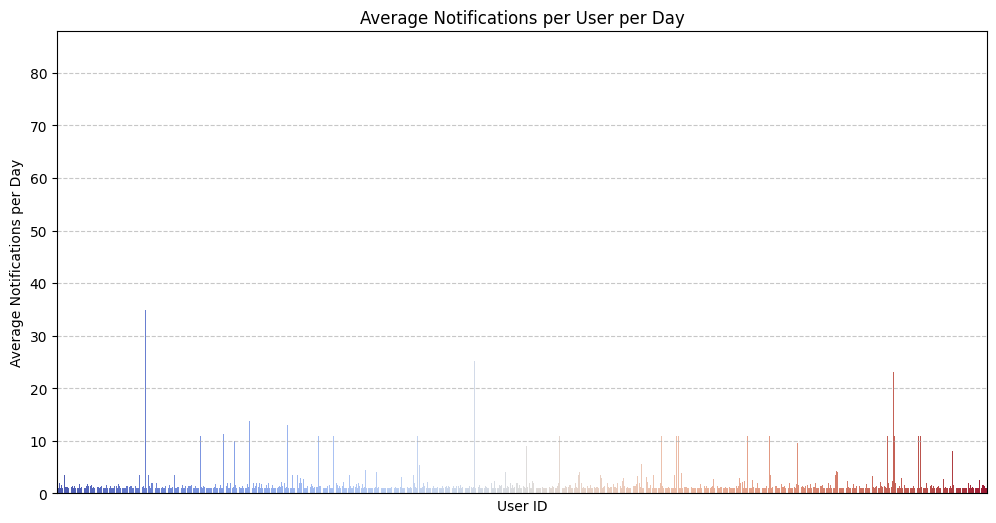

In [ ]:
# Count the number of notifications per user per day
notifications_per_day = df_eda.groupby(['user_id', 'day']).size().reset_index(name='num_notifications')

# Compute the average notifications per user per day
avg_notifications = notifications_per_day.groupby('user_id')['num_notifications'].mean().reset_index()
avg_notifications.columns = ['user_id', 'avg_notifications']

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_notifications, x='user_id', y='avg_notifications', palette="coolwarm")

plt.xlabel("User ID")
plt.ylabel("Average Notifications per Day")
plt.title("Average Notifications per User per Day")
plt.xticks([])  # Hide x-axis labels if there are too many users
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Here we can see that a vast majority recieve around 1 notification per day on average. so we really only have to worry about the people who are very connected to try and send them combined notifications.

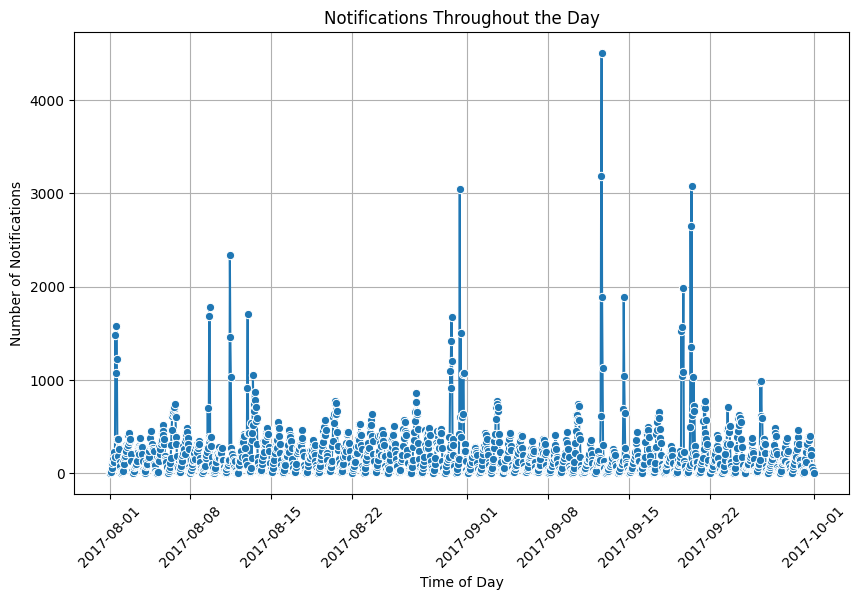

             time_of_day  notifications
0    2017-08-01 00:00:00              3
1    2017-08-01 01:00:00              4
2    2017-08-01 02:00:00             22
3    2017-08-01 03:00:00             13
4    2017-08-01 04:00:00             53
...                  ...            ...
1459 2017-09-30 21:00:00             68
1460 2017-09-30 22:00:00             19
1461 2017-09-30 23:00:00             33
1462 2017-10-01 00:00:00              7
1463 2017-10-01 01:00:00              3

[1464 rows x 2 columns]


In [ ]:
# Step 1: Extract the time of day from the 'timestamp' column
df_eda['time_of_day'] = df_eda['timestamp'].dt.floor('H')  # Rounds to the nearest hour (you can adjust frequency if needed)

# Step 2: Group by the time of day and count the notifications for each time
notifications_per_time_of_day = df_eda.groupby('time_of_day').size().reset_index(name='notifications')

# Step 3: Plot the notifications per time of day throughout the day
plt.figure(figsize=(10, 6))
sns.lineplot(x='time_of_day', y='notifications', data=notifications_per_time_of_day, marker='o')
plt.title('Notifications Throughout the Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Notifications')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Optionally: Display the count of notifications per time of day
print(notifications_per_time_of_day)


In [ ]:
# Step 1: Group by user_id and day to get the number of notifications per day for each user
notifications_per_day = df_eda.groupby(['user_id', 'day']).size().reset_index(name='notifications_per_day')

# Step 2: Calculate the average notifications per day for each user
avg_notifications_per_user = notifications_per_day.groupby('user_id')['notifications_per_day'].mean().reset_index(name='avg_notifications_per_day')

# Step 3: Merge the average notifications per user back to the original DataFrame
df_eda = df_eda.merge(avg_notifications_per_user, on='user_id', how='left')
df_eda.head()

,timestamp,user_id,friend_id,friend_name,day,hour,weekday,time_of_day,avg_notifications_per_day
0,2017-08-01 00:06:47,F62712701E7AF6588B69A44235A6FC,06D188F4064E0D47BD760EEFEB7AAD,Geir,2017-08-01,0,1,2017-08-01 00:00:00,42.403226
1,2017-08-01 00:31:05,DF5BB50FAD220C8D2A8FF9A0DBAA47,588C89FCADD0DBA0E722822513A267,Antim,2017-08-01,0,1,2017-08-01 00:00:00,3.966667
2,2017-08-01 00:35:24,8473CCCE79294CB494D1B42E2B1BAA,EDBB3D240ADBCF6CF175B192630ABB,Σωτήριος,2017-08-01,0,1,2017-08-01 00:00:00,52.754098
3,2017-08-01 01:20:47,CFFEC5978B0A4A05FA6DCEFB2C82CC,2BB0471CAA78ED0FCEE143E175F034,Mona,2017-08-01,1,1,2017-08-01 01:00:00,69.852459
4,2017-08-01 01:21:39,0978C6F8C5093039165B5C571EACC8,45FE4C99C612BEEDE6A34B54C5369D,Laura,2017-08-01,1,1,2017-08-01 01:00:00,1.000000


# Pre-Processing/Feature Engineering

Here, we transform our Data so our model can learn from it, what the best times to send a notification are.

In [48]:
df_model = df_eda.drop(columns=['day', 'hour', 'weekday', 'time_of_day'])[df_eda['avg_notifications_per_day'] >= 3.0]

In [49]:
df_model.timestamp = pd.to_datetime(df_model.timestamp)
df_model['day'] = df_model['timestamp'].dt.date  # Extract the day
df_model['time_of_day_hour'] = df_model['timestamp'].dt.hour # Extract the hour of the day
df_model['time_of_day_minute'] = df_model['timestamp'].dt.hour * 60 + df_model['timestamp'].dt.minute  # Extract the minute of the day 
df_model['weekday'] = df_model['timestamp'].dt.weekday # Extract the weekday

In [50]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203653 entries, 0 to 337655
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   timestamp                  203653 non-null  datetime64[ns]
 1   user_id                    203653 non-null  object        
 2   friend_id                  203653 non-null  object        
 3   friend_name                203653 non-null  object        
 4   avg_notifications_per_day  203653 non-null  float64       
 5   day                        203653 non-null  object        
 6   time_of_day_hour           203653 non-null  int32         
 7   time_of_day_minute         203653 non-null  int32         
 8   weekday                    203653 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(3), object(4)
memory usage: 13.2+ MB


In [51]:
X_train, X_test = train_test_split(df_model, train_size=0.8)

In [52]:
num_cols = ['time_of_day_minute']
cat_cols = []

In [63]:
num_pipeline = Pipeline([
    ('robust_scaler', RobustScaler())
])
cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder())
])

fe_transformer = ColumnTransformer([
    ('num_transform', num_pipeline, num_cols),
    ('cat_transform', cat_pipeline, cat_cols)
])

In [64]:
fe_transformer.fit_transform(X_train)

,num_transform__time_of_day_minute
138474,-0.030986
270292,0.264789
55393,-0.600000
55464,-0.600000
168665,0.039437
...,...
55050,-0.639437
10512,0.095775
115676,-1.087324
168211,-0.045070


# Modelling

Cluster the Notifications into 4 Groups with KMeans algorithm

In [65]:
model_pipeline = Pipeline([
    ('fe_transformer', fe_transformer),
    ('kmeans', KMeans(n_clusters = 4, random_state = 0, n_init='auto'))
])

In [66]:
# Fit the model
model_pipeline.fit(X_train)

# Assign the cluster labels to the dataframe
X_train['cluster'] = model_pipeline.predict(X_train)

# Optionally, you can view the cluster centers and the updated dataframe
print(model_pipeline[-1].cluster_centers_)
print(X_train[['time_of_day_minute', 'cluster']].head())

[[-0.51411521]
 [ 0.92313067]
 [-1.2828829 ]
 [ 0.19084878]]
        time_of_day_minute  cluster
138474                 825        3
270292                 930        3
55393                  623        0
55464                  623        0
168665                 850        3


# Evaluation

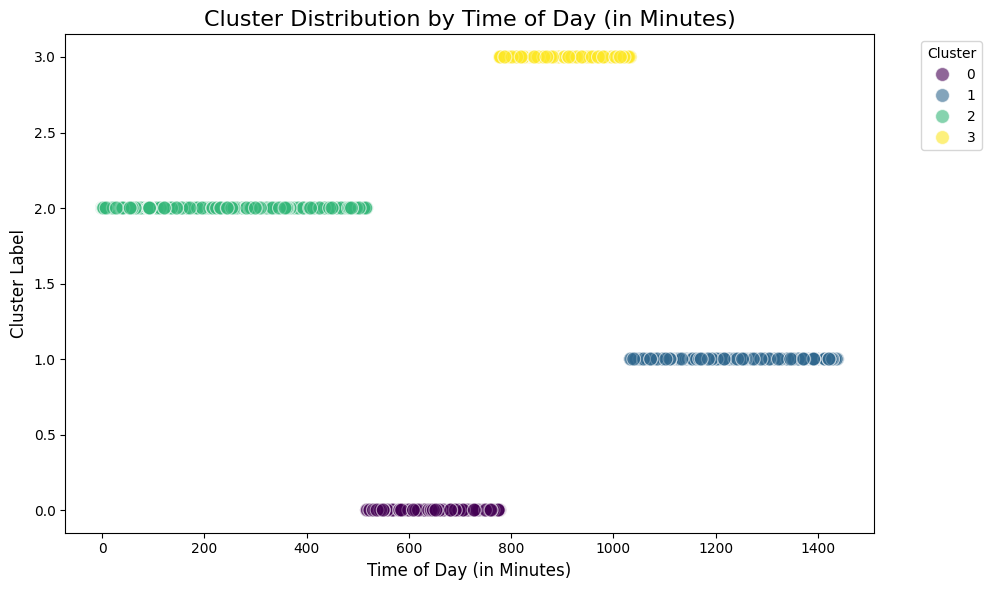

In [67]:
# Assuming 'time_of_day_minute' is your feature and 'cluster_label' is the column with KMeans cluster labels
X_train['cluster_label'] = model_pipeline[-1].labels_  # Assuming you have already fit the KMeans model

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='time_of_day_minute', y='cluster_label', data=X_train, palette='viridis', hue='cluster_label', s=100, alpha=0.6)

# Labels and title
plt.title('Cluster Distribution by Time of Day (in Minutes)', fontsize=16)
plt.xlabel('Time of Day (in Minutes)', fontsize=12)
plt.ylabel('Cluster Label', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

Here you see the four clusters of Notification that the KMeans algorithm has found, to reduce the distance from each other. 

In [69]:
# Group the dataframe by 'cluster_label' and find the maximum 'time_of_day_minute' in each cluster
max_values_per_cluster = X_train.groupby('cluster_label')['time_of_day_minute'].max()

# Display the result
print(max_values_per_cluster)

cluster_label
0     778
1    1438
2     517
3    1033
Name: time_of_day_minute, dtype: int32


In [70]:
def minutes_to_time(minutes):
    hours, minutes = divmod(minutes, 60)
    return f'{int(hours):02d}:{int(minutes):02d}'

# Step 1: Find the maximum value for 'time_of_day_minute' in each cluster
max_values = X_train.groupby('cluster')['time_of_day_minute'].max()

# Step 2: Convert those maximum values to time of day
max_times = max_values.apply(minutes_to_time)

# Display the maximum times for each cluster
print(max_times)

cluster
0    12:58
1    23:58
2    08:37
3    17:13
Name: time_of_day_minute, dtype: object


Here we see that the optimal times to send out notifications is at 08:50, 13:09, 17:15 and 23:59. The last notification can be moved up to a reasonable Time, maybe somewhere around 20:00 and 21:00 so that no notifications come up in the night.

In [71]:
X_train.columns

Index(['timestamp', 'user_id', 'friend_id', 'friend_name',
       'avg_notifications_per_day', 'day', 'time_of_day_hour',
       'time_of_day_minute', 'weekday', 'cluster', 'cluster_label'],
      dtype='object')

# Create the desired output for this set of Notifications

In [ ]:
# To Do

# Conclusion

The vast majority of customers doesn't need clustered Notifications. For those who are well connected, we can train a KMeans-Clustering algorithm to predict the best times to send them a notification to keep their annoyance to a minimum. Alternatively we could ask them to enter their preferred notification time, so they have time to look at the notifications. 